In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


In [107]:
# načtení dat pro první úlohu
first_task_data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 1')
first_task_data


,uloha_1 a),uloha_1 b)_prior,skupina,uloha_1 b)_pozorování
0,2.0,3.634785,0,3.626656
1,2.0,2.868113,0,3.008269
2,1.0,2.149160,0,2.989829
3,3.0,4.263065,0,2.371630
4,0.0,2.594745,0,4.009366
...,...,...,...,...
99995,NaN,1.725637,9999,NaN
99996,NaN,4.048414,9999,NaN
99997,NaN,3.000662,9999,NaN
99998,NaN,3.058451,9999,NaN


1.666966696669667


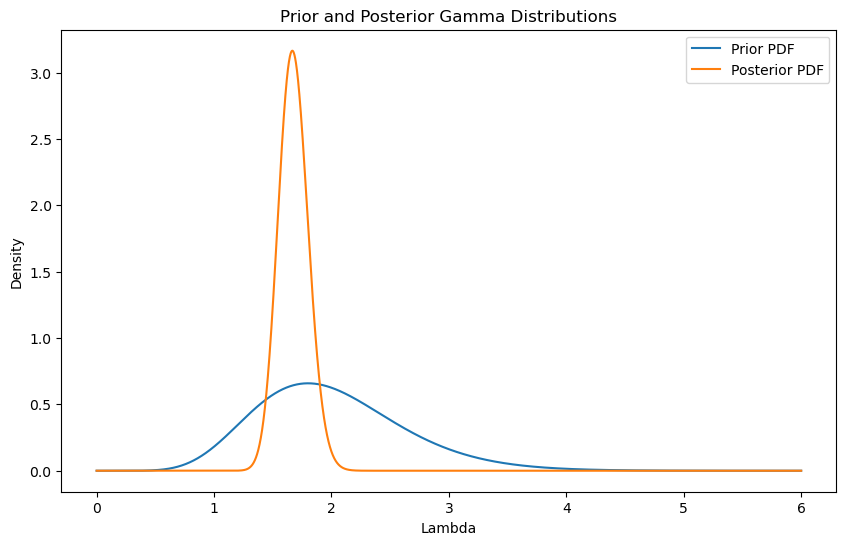

In [134]:
subtask_a_data = first_task_data["uloha_1 a)"].dropna()

alpha_prior = 10.0
beta_prior = 5.0

alpha_posterior = alpha_prior + subtask_a_data.sum()
beta_posterior = beta_prior + subtask_a_data.size

lambda_values = np.linspace(0, 6, 10000)

prior_pdf = stats.gamma.pdf(lambda_values, a=alpha_prior, scale= 1 / beta_prior)
posterior_pdf = stats.gamma.pdf(lambda_values, a=alpha_posterior, scale= 1 / beta_posterior)

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, prior_pdf, label='Prior PDF')
plt.plot(lambda_values, posterior_pdf, label='Posterior PDF')
plt.title('Prior and Posterior Gamma Distributions')
plt.xlabel('Lambda')
plt.ylabel('Density')
plt.legend()
plt.show()


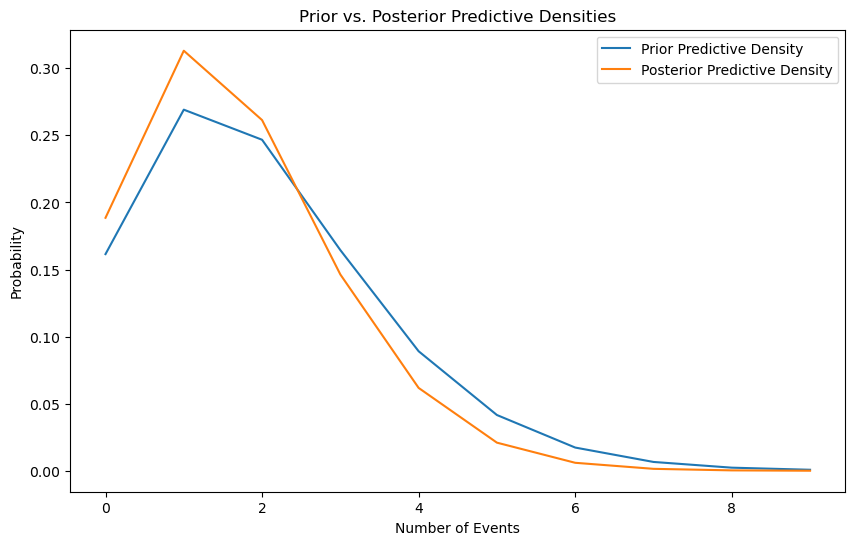

In [127]:
r_prior = alpha_prior
r_posterior = alpha_posterior
p_prior = beta_prior / (beta_prior + 1)
p_posterior = beta_posterior / (beta_posterior + 1)

padding = 5
max_connections = subtask_a_data.max()

x_values = np.arange(0, max_connections + padding)

prior_predictive_probs = stats.nbinom.pmf(x_values, r_prior, p_prior)
posterior_predictive_probs = stats.nbinom.pmf(x_values, r_posterior, p_posterior)

plt.figure(figsize=(10, 6))
plt.plot(x_values, prior_predictive_probs, label='Prior Predictive Density')
plt.plot(x_values, posterior_predictive_probs, label='Posterior Predictive Density')
plt.title('Prior vs. Posterior Predictive Densities')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.legend()
plt.show()


Porovnat intervalové odhady.. TODO!

In [118]:
lower_percentile = 0.025  
upper_percentile = 0.975

lambda_prior_lower = stats.gamma.ppf(lower_percentile, a=alpha_prior, scale=1/beta_prior)
lambda_prior_upper = stats.gamma.ppf(upper_percentile, a=alpha_prior, scale=1/beta_prior)

lambda_posterior_lower = stats.gamma.ppf(lower_percentile, a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_upper = stats.gamma.ppf(upper_percentile, a=alpha_posterior, scale=1/beta_posterior)

print("95% interval spolehlivosti pro parametr 𝜆 z aprio. rozdělení: <{}, {}>".format(lambda_prior_lower, lambda_prior_upper))
print("95% interval spolehlivosti pro parametr 𝜆 z apost. rozdělení: <{}, {}>".format(lambda_posterior_lower, lambda_posterior_upper))


95% interval spolehlivosti pro parametr 𝜆 z aprio. rozdělení: <0.9590777392264868, 3.416960690283833>
95% interval spolehlivosti pro parametr 𝜆 z apost. rozdělení: <1.4376938284869922, 1.9327207471868797>


Porovnat bodové odhady... TODO!

In [135]:
lambda_posterior_mean = alpha_posterior / beta_posterior
lambda_posterior_median = stats.gamma.median(a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_mode = lambda_values[posterior_pdf.argmax()]

print("Bodový odhad parametru 𝜆 na základě střední hodnoty:", lambda_posterior_mean)
print("Bodový odhad parametru 𝜆 na základě mediánu:", lambda_posterior_median)
print("Bodový odhad parametru 𝜆 na základě modusu:", lambda_posterior_mode)


Bodový odhad parametru 𝜆 na základě střední hodnoty: 1.6761904761904762
Bodový odhad parametru 𝜆 na základě mediánu: 1.6730169441241727
Bodový odhad parametru 𝜆 na základě modusu: 1.666966696669667


Vybrat jeden pro aprio, jeden pro posterio a komentovat... TODO!

In [131]:
print(r_prior, p_prior)
print(r_posterior, p_posterior)

events_prior_mean = r_prior * (1.0 - p_prior) / p_prior
events_prior_median = stats.nbinom.ppf(0.5, r_prior, p_prior)
events_prior_mode = x_values[prior_predictive_probs.argmax()]


print("(Apriori) Bodový odhad počtu pozorování na základě střední hodnoty:", events_prior_mean)
print("(Apriori) odhad počtu pozorování na základě mediánu:", events_prior_median)
print("(Apriori) odhad počtu pozorování na základě modusu:", events_prior_mode)


events_posterior_mean = r_posterior * (1.0 - p_posterior) / p_posterior
events_posterior_median = stats.nbinom.ppf(0.5, r_posterior, p_posterior)
events_posterior_mode = x_values[prior_predictive_probs.argmax()]

print("(Aposteriori) Bodový odhad počtu pozorování na základě střední hodnoty:", events_posterior_mean)
print("(Aposteriori) Bodový odhad počtu pozorování na základě mediánu:", events_posterior_median)
print("(Aposteriori) Bodový odhad počtu pozorování na základě modusu:", events_posterior_mode)


10.0 0.8333333333333334
176.0 0.9905660377358491
(Apriori) Bodový odhad počtu pozorování na základě střední hodnoty: 1.9999999999999996
(Apriori) odhad počtu pozorování na základě mediánu: 2.0
(Apriori) odhad počtu pozorování na základě modusu: 1.0
(Aposteriori) Bodový odhad počtu pozorování na základě střední hodnoty: 1.6761904761904758
(Aposteriori) Bodový odhad počtu pozorování na základě mediánu: 1.0
(Aposteriori) Bodový odhad počtu pozorování na základě modusu: 1.0


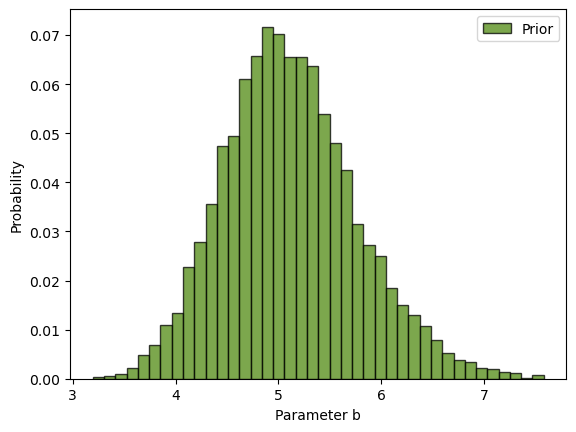

In [219]:
subtask_b_prior = first_task_data[["uloha_1 b)_prior", "skupina"]].groupby("skupina").max()
subtask_b_observations = first_task_data["uloha_1 b)_pozorování"].dropna()
 
# print(subtask_b_observations)

prior_freq, bins_prior = np.histogram(subtask_b_prior, bins=40)
normalized_prior_freq = prior_freq / prior_freq.sum()


plt.hist(bins_prior[:-1], bins_prior, weights=normalized_prior_freq, label='Prior', alpha=0.75, color='#508A11', edgecolor='black')


plt.xlabel('Parameter b')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [218]:
# načtení dat pro druhou úlohu
second_task_data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 2')
second_task_data


,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms]
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39
